<a href="https://colab.research.google.com/github/shnhrtkyk/JTCcode/blob/main/05_%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AB%E3%82%88%E3%82%8B%E8%A1%A8%E9%9D%A2%E3%81%AE%E5%86%8D%E6%A7%8B%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDFによる点群の表面再構成

## 使用する手法
Implicit Neural Representations with Periodic Activation Functions
https://www.vincentsitzmann.com/siren/


## コードをクローン

In [24]:
!git clone https://github.com/vsitzmann/siren.git

Cloning into 'siren'...
remote: Enumerating objects: 193, done.
remote: Total 193 (delta 0), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (193/193), 2.18 MiB | 4.26 MiB/s, done.
Resolving deltas: 100% (68/68), done.


## ライブラリインストール

In [25]:
!pip install matplotlib
!pip install scipy
!pip install scikit-image
!pip install scikit-video
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install h5py
!pip install opencv-python
!pip install cmapy
!pip install tensorboard
!pip install ConfigArgParse
!pip install plyfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/sim

In [26]:
%cd siren
!ls

/content/siren/siren
data		   experiment_scripts	make_figures.py  sdf_meshing.py
dataio.py	   explore_siren.ipynb	meta_modules.py  torchmeta
diff_operators.py  LICENSE		modules.py	 training.py
environment.yml    loss_functions.py	README.md	 utils.py


## SILENとは

#### SDF
一般的によく用いられる3次元のデータ表現には点群、メッシュ、ボクセル、SDFといった種類があります。
点群: 物体を構成する頂点のみによってデータのおおよその形を表します。
メッシュ: 点群に頂点同士の結びつき(面)を加えることでデータを表します。
ボクセル: 3次元の空間を細かなブロックに区切り、ブロック単位で物体の領域を表します。
SDF(Signed Distance Field;符号付き距離場): 3次元空間の各座標に、そこから最も近い物体表面までの符号付き距離を割り振ることで、距離が0となる部分を表面として表します。座標に距離を割り振る関数もSDF(Signed Distance Function)と表記されます。
これらのデータ表現のうち、メモリ効率やニューラルネットワークとの相性、既存レンダリング手法との相性といった点で、注目を集めているのがSDFです。SDFでは、物体表面の外側にある空間に正の距離、内側にある空間に負の距離を割り当てます。この符号付き距離場(あるいは割り当て関数)を保存しておくことで、距離が0となる部分を抽出すればデータを復元できるようになります。


SDFをベースとした表現方法として、座標に対する距離の割り当てをニューラルネットワークで近似する物があります。このようにデータ表現となる関数をニューラルネットワークで近似する手法は「ニューラル陰関数表現」と呼ばれています。

ニューラル陰関数表現は当初、新しいデータへの汎化を目的とするエンコーダ・デコーダ型の生成モデルにおいてデコーダとして利用されていました[1][2]。これらの手法では、エンコーダで物体の大まかな形状を表す潜在特徴量を学習します。同時に、デコーダでは潜在特徴量と座標とを条件として、その座標における最も近い表面までの距離を学習します。これによって、物体形状の潜在特徴量を元にSDFを介した3次元物体生成を可能としていました。
一方でSIREN[3]やOverfitSDF[4]では、既存の機械学習手法のように新しいデータへの汎化を目的とするのではなく、一つのデータポイントについて詳細な学習をするという少し変わったタスク設定をしています。一つのデータポイントが持つ座標と距離の対応関係をもとにニューラルネットワークによるSDFの近似を行うことで、データ内の空間に対する汎化が期待できます。これにより、データ利用時に解像度に縛られることなく取り出せるというメリットがあります。加えて、ストレージ上の容量面での圧縮も期待できると言われています[4]。
また、3次元データに限らず画像の陰関数表現獲得においても、SIRENモデルを用いた画像圧縮が行われており、条件によっては非常に小さい容量でもJpegに並ぶ圧縮が可能であると言われています[5]。

このような3次元の陰関数表現からデータを取り出す方法として、主に二つの方法が考えられます。
一つは、3次元のままのデータとして取り出す方法です。物体を含む空間の座標をモデルに入力し、得られた距離の絶対値に閾値を設けて点群やメッシュとして復元する方法です。閾値は入力座標のスケールに合わせて0に近い値に設定します。
もう一つは、ある視点から見た際の2次元画像として取り出す方法です。この場合にはレイマーチングというアルゴリズムが用いられます。空間における視点の位置と視線の方向をそれぞれ定めた上で視線を飛ばし、視線の先に物体表面があるか否かを確認し描画するアルゴリズムです。視線を飛ばす処理では、視点から見ている先に向けてその位置におけるモデル出力の距離分だけ視線を進め、物体表面にたどり着くか一定回数進むまで確認します。

#### 点群データからの陰関数表現学習
モデルが前提としているSDFには「表面で囲まれた閉鎖的な空間を持つ(＝表面を挟んで正と負の距離を持つ)データでなければ表現できない」という問題点があります。実際の3次元データには必ずしも閉鎖的な空間がある訳ではありません。例えばLiDARのように、ある方向から光を当てた反射によって対象を計測する手法では、得られるデータは非常に平面的な点群データです。そして、平面的な点群データから計算できるのは符号を持たない距離(Unsigned Distance)になります。
SDFを想定した手法で閉鎖的な空間を持たないデータや符号を持たない距離を扱う問題点として、既存手法の学習がうまくいかないことや、出力アルゴリズムのレイマーチングが収束しないことが考えられます。この問題に対して、SAL[2]では符号を持たない距離を教師データとして符号付き距離を学習するように、ニューラルネットワークモデルを設計しています。しかし、SALは最終的な出力でSDFに頼るため、点群からの学習はできても平面データへの適用は難しいです。NDF[6]では、符号なしの距離場(UDF; Unsigned Distance Field)における汎化的な表面構成モデルの実装や描画アルゴリズムの改良を提案しています。NDF論文から、ニューラルネットワークの出力が符号を持たない距離であっても、描画アルゴリズムに少し改良を加えることでデータを復元できることがわかります。



#### SIREN  
これまでSDFを近似するニューラルネットワークモデルには活性化関数をReLUにしたMLPが多く使われてきました。それに対してこれまでSDFを近似するニューラルネットワークモデルには活性化関数をReLUにしたMLPが多く使われてきました。それに対してSIRENモデルでは活性化関数をSin関数に変更することで、画像や音声、3次元空間など信号として扱えるデータについてReLUモデルでは活性化関数をSin関数に変更することで、画像や音声、3次元空間など信号として扱えるデータについてReLU MLPよりも詳細な表現を得られると言われています。

$y^l =\sin(W ^l y ^{l−1} +b^l)$

SIRENモデルでは各層の活性化関数をSin関数としているため、その導関数もSin関数として表せます。 
このため、SIRENモデルの導関数もまた表現力の高いSIRENとなり、詳細な表現獲得が可能となります。








## 学習

#### 入力の確認

実験にはウサギの点群を用います。

In [27]:
!wget http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz && tar -xvf bunny.tar.gz 



--2023-04-06 06:29:11--  http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz
Resolving graphics.stanford.edu (graphics.stanford.edu)... 171.67.77.70
Connecting to graphics.stanford.edu (graphics.stanford.edu)|171.67.77.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4894286 (4.7M) [application/x-gzip]
Saving to: ‘bunny.tar.gz’

bunny.tar.gz        100%[===================>]   4.67M  1.39MB/s    in 3.3s    

2023-04-06 06:29:15 (1.39 MB/s) - ‘bunny.tar.gz’ saved [4894286/4894286]

bunny/
bunny/data/
bunny/data/README
bunny/data/bun.conf
bunny/data/bun.conf~
bunny/data/bun000.ply
bunny/data/bun045.ply
bunny/data/bun090.ply
bunny/data/bun180.ply
bunny/data/bun270.ply
bunny/data/bun315.ply
bunny/data/chin.ply
bunny/data/ear_back.ply
bunny/data/top2.ply
bunny/data/top3.ply
bunny/reconstruction/
bunny/reconstruction/README
bunny/reconstruction/bun_zipper.ply
bunny/reconstruction/bun_zipper_res2.ply
bunny/reconstruction/bun_zipper_res3.ply
bunny/reconstruction/

In [28]:
!pip install open3d==0.16

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import trimesh
mesh = trimesh.load('bunny/reconstruction/bun_zipper.ply')

使用する関数の定義

In [34]:

%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


def vis_f(sdf, points=None, d=1.5):
  y, x = np.mgrid[-d:d:256j, -d:d:256j]
  coords = np.stack([x, y], -1).astype(np.float32)
  dist = sdf(coords)[...,0]
  f = pl.figure(figsize=(10, 8))
  pl.axis('equal')
  pl.grid()
  pl.contourf(x, y, dist, 16);
  pl.colorbar();
  pl.contour(x, y, dist, levels=[0.0], colors='white');

  if points is not None:
    dist, point_grad = val_and_grad(sdf, points)
    x, y = points.numpy().T
    u, v = point_grad.numpy().T
    pl.quiver(x, y, u, v, color='white')

  pl.show()

def val_and_grad(sdf, points):
  with tf.GradientTape() as g:
    g.watch(points)
    dist = sdf(points)
  point_grad = g.gradient(dist, points)
  return dist, point_grad

def loss_f(sdf, points, bg_point_n=500):
  n, dim = points.shape
  all_points = tf.concat([points, tf.random.uniform([bg_point_n, dim], -2.0, 2.0)], 0)
  dist, grad = val_and_grad(sdf, all_points)
  surface_loss = tf.reduce_mean(tf.square(dist[:n]))
  offsurface_loss = tf.reduce_mean(tf.exp(-tf.square(dist[n:]/0.02)))
  grad_norm2 = tf.reduce_sum(tf.square(grad), -1)
  grad_loss = tf.reduce_mean(tf.square(grad_norm2-1.0))
  return surface_loss*1e2 + grad_loss + offsurface_loss

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


ウサギの形状と初期値の確認

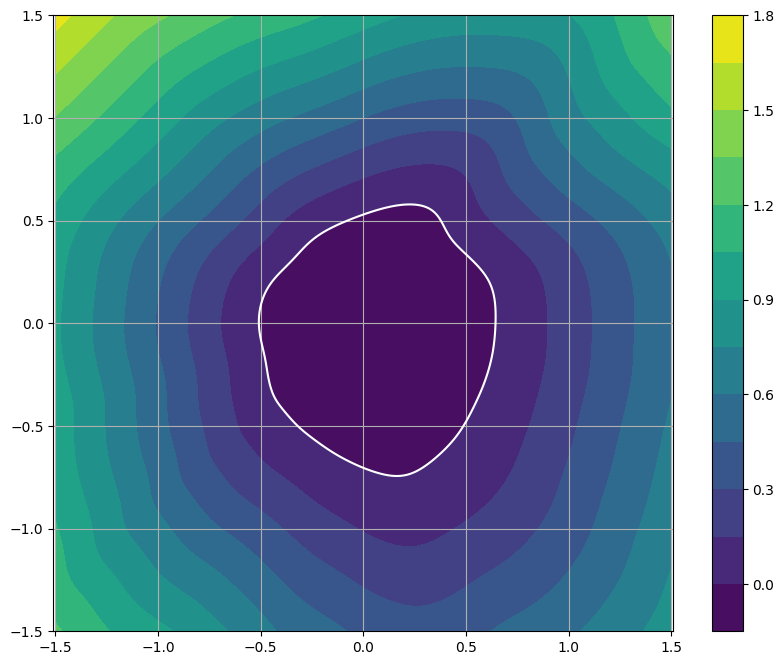

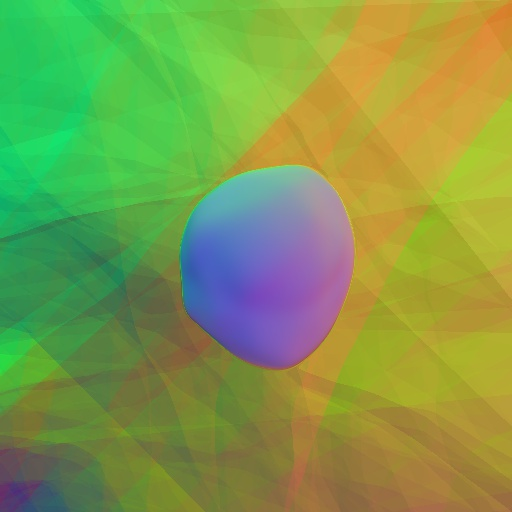

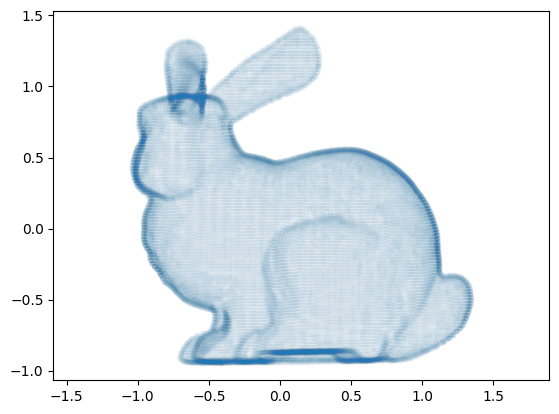

In [32]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

sdf = Sequential(
  [Activation(lambda x:x*50.0)] + 
  [Dense(80, tf.nn.swish) for i in range(6)] + 
  [Dense(1,
      kernel_initializer=tf.initializers.constant(1.0/80),
      bias_initializer=tf.initializers.constant(-0.1))]
)

# for visualization
def sdf_slice(xy):
  return sdf(tf.concat([xy, xy[...,:1]*0.0], -1))
vis_f(sdf_slice)

@tf.function(experimental_compile=True)
def render(sdf, R, offset, fov=0.7, size=512):
  x = tf.linspace(-fov, fov, size)
  x, y = tf.meshgrid(x, -x)
  rays = tf.stack([x, y, -tf.ones_like(x)], -1)
  rays = tf.nn.l2_normalize(rays, -1) @ R
  pos0 = np.float32([[0, 0, 2.5]]) @ R
  pos = pos0+tf.zeros_like(rays)
  for i in tf.range(40):
    pos += rays*(sdf(pos)-offset)
  dist, normal = val_and_grad(sdf, pos)
  return normal*0.5+0.5
imshow(render(sdf, tf.eye(3), 0.0))

loss_log = []
lr0 = 3e-3
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [3000, 6000, 8000], [lr0, lr0*0.3, lr0*0.1, lr0*0.03])
trainer = tf.optimizers.Adam(lr)

@tf.function
def train_step(points):
  with tf.GradientTape() as g:
    loss = loss_f(sdf, points, 2000)
  params = g.watched_variables()
  grads = g.gradient(loss, params)
  trainer.apply_gradients(zip(grads, params))
  return loss

verts = np.float32(mesh.vertices)
verts -= verts.mean(0)
verts /= verts.ptp()*0.4
x, y, z = verts.T
pl.axis('equal')
pl.plot(x, y, '.', alpha=0.02);


### 訓練

初期値の値は、丸い形状でした。しかし、学習を進めていくと徐々にウサギの点群の表面を再構成するような挙動を示します。

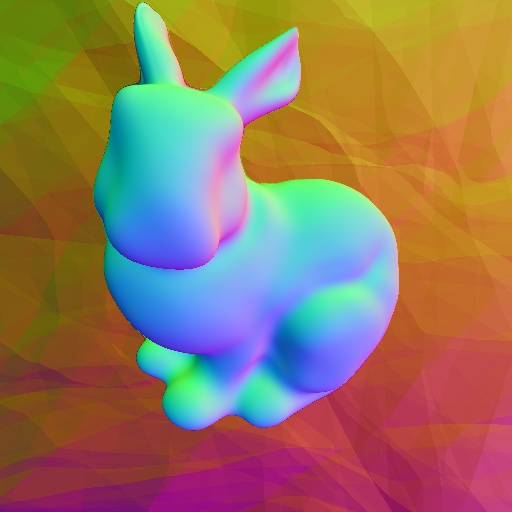

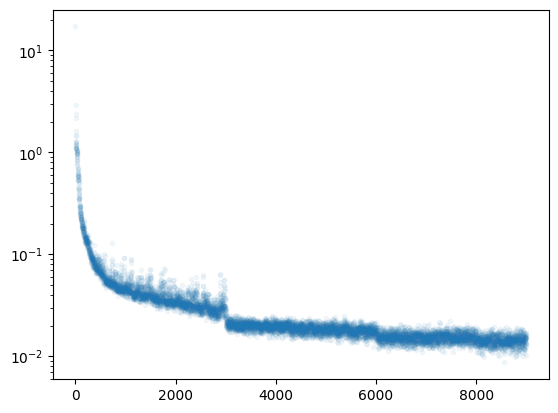

9001 0.015014051


In [33]:
for i in range(10000):
  points = verts[np.random.choice(len(verts), 3000, False)]
  loss = train_step(points)
  loss_log.append(loss.numpy())
  if i>100 and i % 10**int(np.log10(i+1)) == 0:
    clear_output(True)
    R = np.float32(trimesh.transformations.euler_matrix(0.5, 0.5, 0.0)[:3,:3])
    imshow(render(sdf, R, 0.0))
    pl.yscale('log')
    pl.plot(loss_log, '.', alpha=0.05);
    pl.show()
    print(len(loss_log), loss.numpy())